# Домашнее задание 2.
Dynamical Forecasting Methods

In [1]:
import os
import math as m
import numpy as np
import pandas as pd
from scipy import *
import scipy.linalg
import warnings
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import scaleogram as scg
from scipy.fftpack import fft
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
import seaborn as sns
from tqdm.auto import tqdm
from scipy.spatial import distance
sns.set_style("darkgrid")

In [161]:
warnings.simplefilter('ignore')

plt.rcParams['figure.figsize'] = 16, 8
plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 8

In [162]:
def HankelMatrix(X, L):
    N = X.shape[0]
    return scipy.linalg.hankel(X[ : N - L + 1], X[N - L : N])

# Пример

Показания акселерометра мобильного устройства с частотой записи 500Гц

In [163]:
DATA_PATH = "../data/walk_example.csv"
data = pd.read_csv(DATA_PATH, delimiter =',')

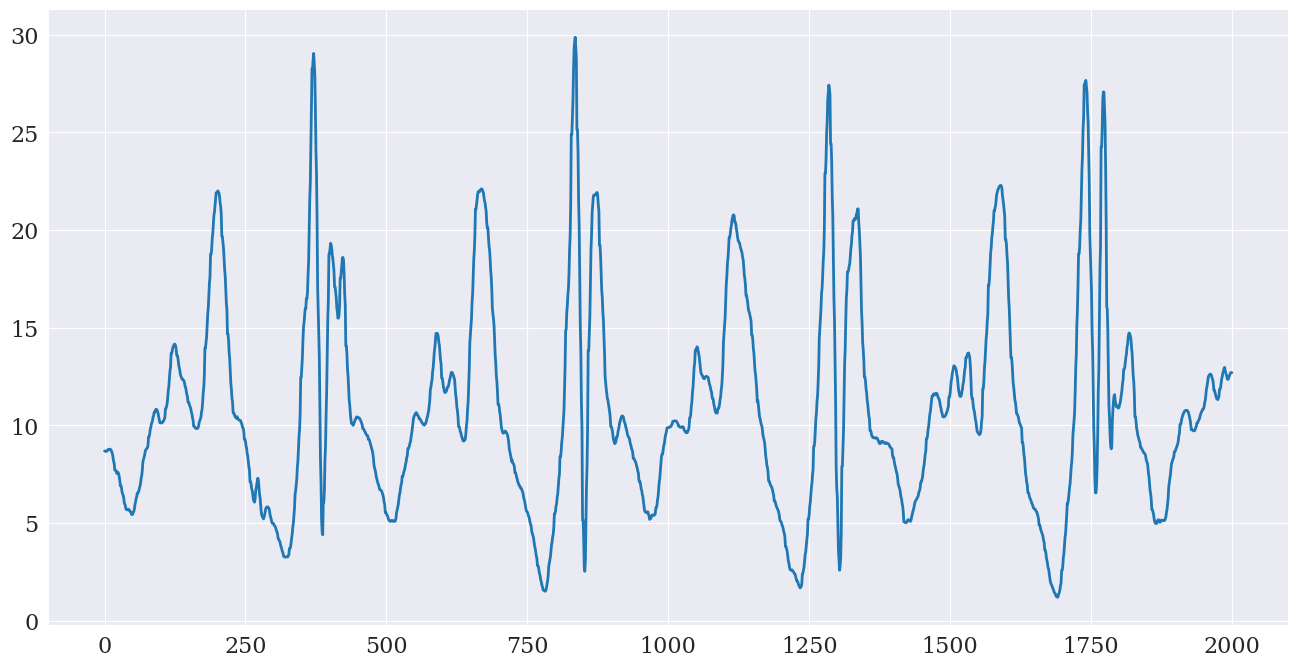

In [164]:
# исследуемый временной ряд - корень из суммы квадратов показаний акселерометра по осям
data['ts'] = data[['X_value', 'Y_value', 'Z_value']].pow(2).sum(axis = 1).pow(0.5)
data.loc[:2000,'ts'].plot()
plt.show()

In [165]:
X = HankelMatrix(data['ts'], 500)
X.shape

(39502, 500)

In [166]:
from sklearn.decomposition import KernelPCA, PCA

Пример восстановленной фазовой траектории в пространстве размерности 3

временной ряд -> метод задержек -> PCA -> 3 главные компоненты, как оценка координат изначальной системы

In [167]:
pca = PCA(n_components=3)
X_PCA = pca.fit_transform(X)

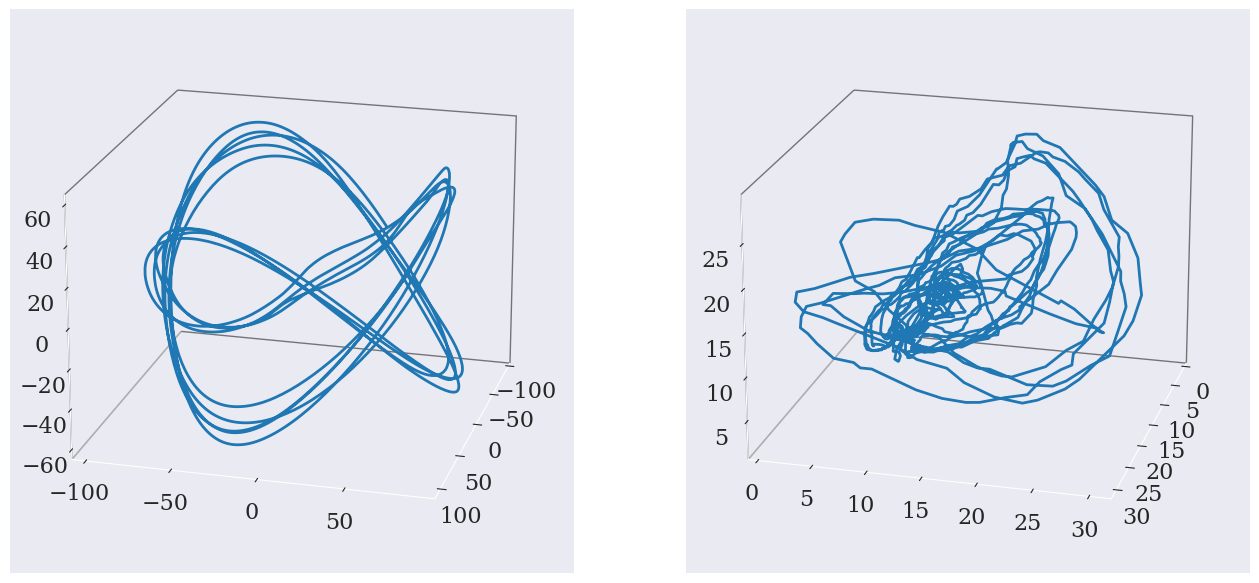

In [168]:
fig = plt.figure(figsize=plt.figaspect(0.5))
ax = fig.add_subplot(1,2,1, projection='3d')
# метод  PCA 
ax.plot(
    X_PCA[:2000,0],
    X_PCA[:2000,1],
    X_PCA[:2000,2]
)

ax.view_init(elev=20, azim=15)

ax.grid(False)
ax.xaxis.pane.set_edgecolor('black')
ax.yaxis.pane.set_edgecolor('black')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax2 = fig.add_subplot(1,2,2, projection='3d')
# 3 случайные точки из предыстории
ax2.plot(
    X[:2000,0],
    X[:2000,20],
    X[:2000,30]
)

ax2.view_init(elev=20, azim=15)

ax2.grid(False)
ax2.xaxis.pane.set_edgecolor('black')
ax2.yaxis.pane.set_edgecolor('black')
ax2.xaxis.pane.fill = False
ax2.yaxis.pane.fill = False
ax2.zaxis.pane.fill = False


plt.show()

# Задание

Набор данных включает в себя данные временных рядов, генерируемые датчиками акселерометра и гироскопа.
https://github.com/mmalekzadeh/motion-sense/tree/master

1. Выбрать один из датасетов ходьбы ```wlk_*``` или бега ```jog_*``` для одного человека ```sub_*```
2. Проанализировать связь между показателями акселерометра и гироскопа
    - Графики автокорреляций
    - Тест Грэнджера на причинность ([пример](https://phdinds-aim.github.io/time_series_handbook/04_GrangerCausality/04_GrangerCausality.html))
    - CCM ([пример](https://phdinds-aim.github.io/time_series_handbook/06_ConvergentCrossMappingandSugiharaCausality/ccm_sugihara.html))
3. Посторить фазовую траекторию (пример выше), проанализировать формы полученных множеств (Если по CCM делается вывод о связи временных рядов, то их фазовые траектории будут похожи)    
    - По 3 случайным точкам из предыстории
    - Методом PCA
    - Другим методом снижения размерности (например, t-sne, kernel PCA, UMAP и тд)
4. Разложить временной ряд на компоненты
    - Методом ```from statsmodels.tsa.seasonal import seasonal_decompose```
    - Методом ```from scipy.fftpack import fft``` (как в семинаре)
    - Методом SSA ([пример](https://www.kaggle.com/code/jdarcy/introducing-ssa-for-time-series-decomposition/notebook)) (как в семинаре)
    - Обучить и проанализировать результаты двух ARIMA моделей на начальном и обработанном с помощью SSA (только для акселерометра)

In [169]:
# предварительно загруженный датасет
print(os.listdir('./'))

['.ipynb_checkpoints', 'A_DeviceMotion_data', 'B_Accelerometer_data', 'C_Gyroscope_data', 'HW2_ts_dynamical_forecasting(Ильгам).ipynb', 'HW2_ts_dynamical_forecasting.ipynb']


In [170]:
data = pd.read_csv('./A_DeviceMotion_data/jog_9/sub_11.csv')
data = data[[
    'rotationRate.x',
    'rotationRate.y',
    'rotationRate.z',
    'userAcceleration.x',
    'userAcceleration.y',
    'userAcceleration.z'
]]

In [171]:
# подготовка временных рядов
data['rot'] = data[['rotationRate.x', 'rotationRate.y', 'rotationRate.z']].pow(2).sum(axis = 1).pow(0.5)
data['acc'] = data[['userAcceleration.x', 'userAcceleration.y', 'userAcceleration.z']].pow(2).sum(axis = 1).pow(0.5)

In [172]:
data

rotationRate.x  rotationRate.y  rotationRate.z  userAcceleration.x  \
0          -2.200414       -2.217282       -1.587169            1.300639   
1           1.429705        0.241446       -2.087324            1.112505   
2           6.051980        8.029474        0.877934            1.404574   
3           2.453038        3.069171        3.822400            0.849460   
4           3.430108       -2.662345        5.985831           -0.563324   
...              ...             ...             ...                 ...   
3279       -4.722668       -0.356643       -4.010896            1.455961   
3280       -3.652383       -3.354825       -3.483627            0.050116   
3281       -3.359644       -4.180281       -2.972051           -0.606515   
3282       -1.946721       -3.709833       -0.902184            0.658234   
3283       -0.199163       -3.326193        0.209800            0.601526   

      userAcceleration.y  userAcceleration.z        rot       acc  
0               3.591460           -1.633581   3.503893  4.154375  
1              -2.075541            0.358870   2.541510  2.382084  
2              -2.198334           -1.567041  10.093051  3.043209  
3               0.391364           -1.770550   5.481601  2.002397  
4               2.874439           -1.205995   7.394856  3.167674  
...                  ...                 ...        ...       ...  
3279            1.655349            0.159666   6.206293  2.210316  
3280            0.824770           -0.847036   6.060562  1.183312  
3281           -0.102633           -0.604358   6.131480  0.862347  
3282           -1.244031           -0.570538   4.285618  1.518683  
3283           -1.555311           -0.739315   3.338749  1.824120  

[3284 rows x 8 columns]

<Axes: >

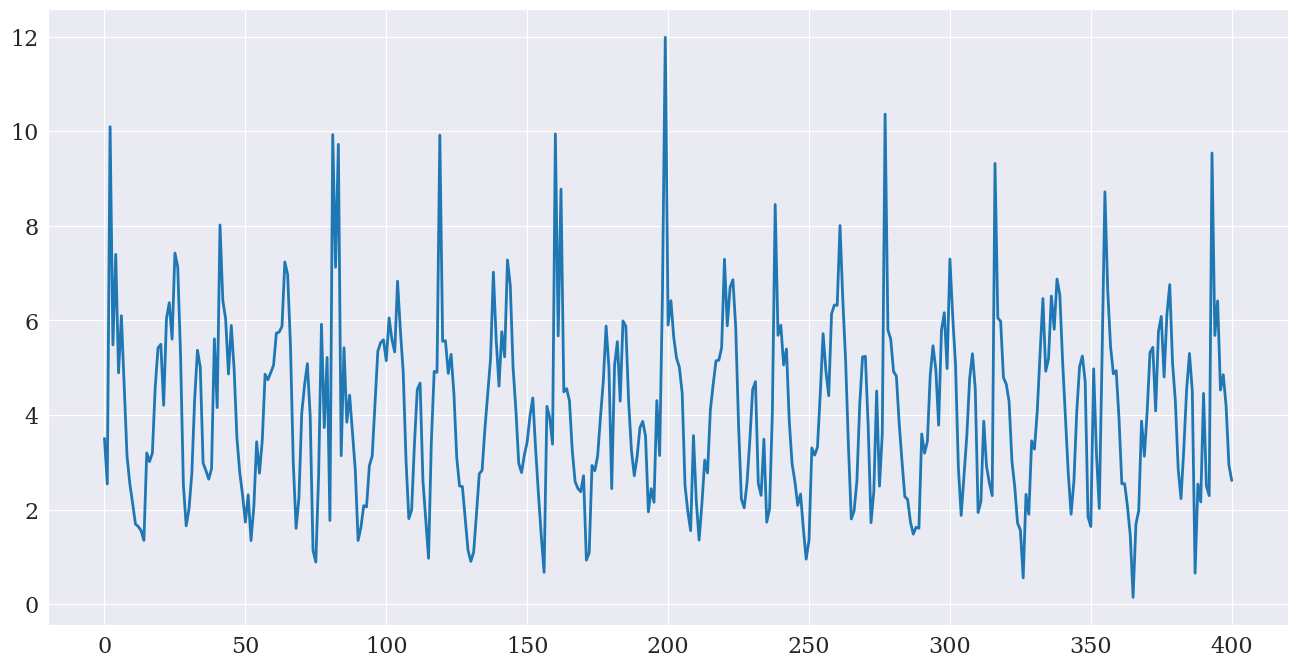

In [173]:
data.loc[:400,'rot'].plot()

<Axes: >

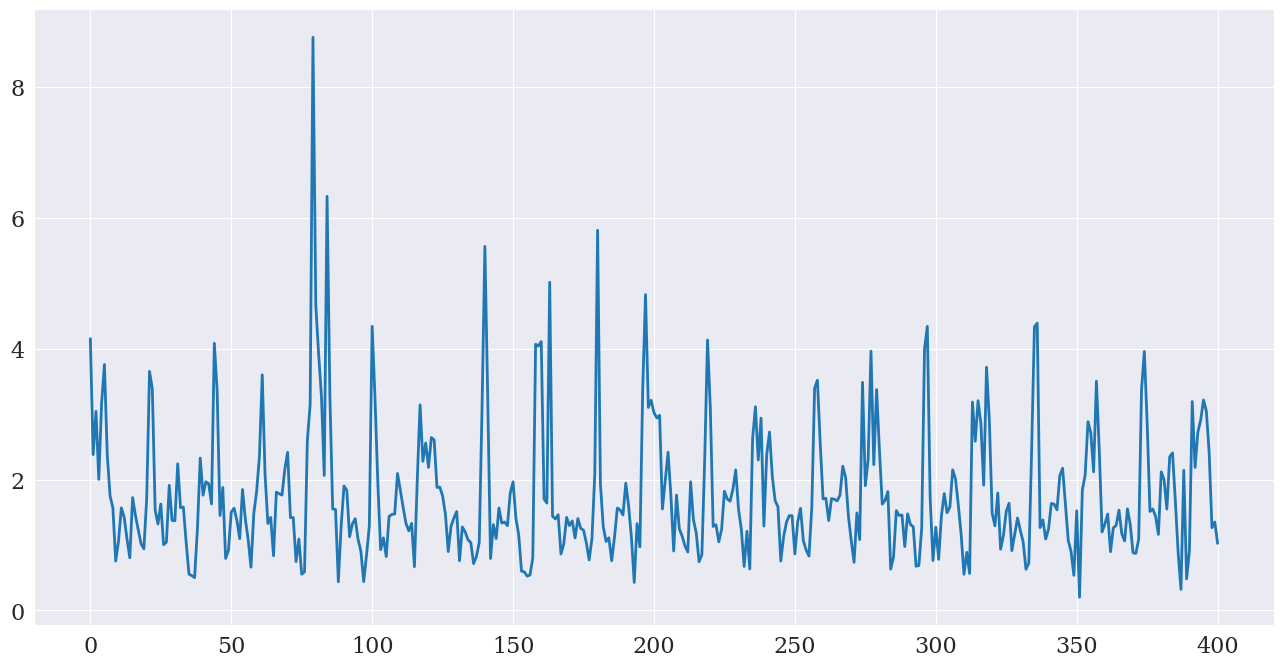

In [174]:
data.loc[:400,'acc'].plot()

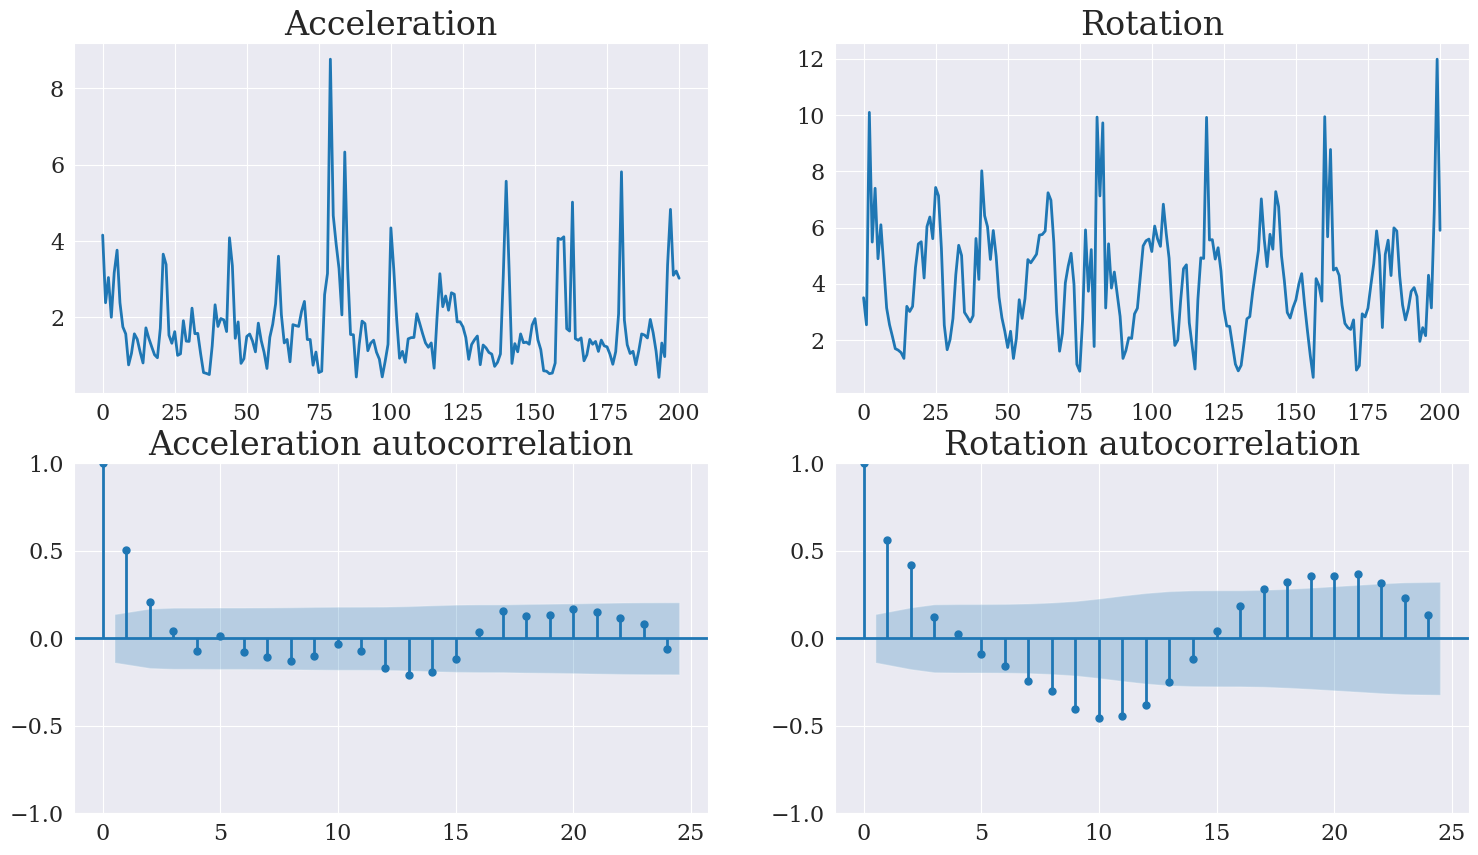

In [175]:
first_k = 200

fig, axes = plt.subplots(2, 2, figsize = (18,10))


axes[0,0].plot(data.loc[:first_k,'acc'])
axes[0,1].plot(data.loc[:first_k,'rot'])

plot_acf(data.loc[:first_k,'acc'], ax=axes[1,0], alpha=0.05)
plot_acf(data.loc[:first_k,'rot'], ax=axes[1,1], alpha=0.05)

axes[0,0].set_title("Acceleration")
axes[1,0].set_title("Acceleration autocorrelation")
axes[0,1].set_title("Rotation")
axes[1,1].set_title("Rotation autocorrelation")


plt.show()

  0%|          | 0/59 [00:00<?, ?it/s]

AIC     40
BIC      9
HQIC    19
FPE     40
dtype: int32


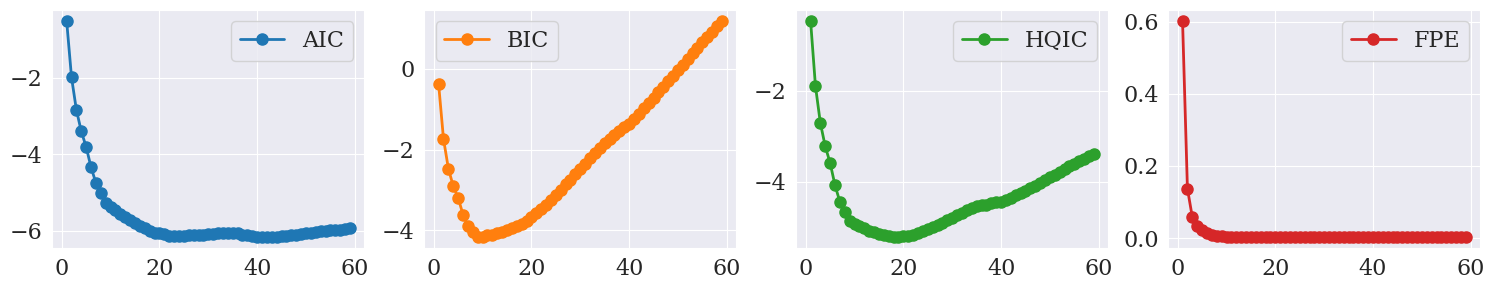

In [176]:
def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,60)
    for i in tqdm(p):
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))
    plt.show()
    
select_p(data)

In [177]:
def granger_causation_matrix(data, variables, p, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the time series.
    The rows are the response variables, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in tqdm(df.columns, colour="#44AA44"):
        for r in tqdm(df.index, colour="#4444AA", leave=False):
            test_result = grangercausalitytests(data[[r, c]], p, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],5) for i in range(p)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [178]:
granger_causation_matrix(data, data.columns, p=9)  

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

rotationRate.x_x  rotationRate.y_x  rotationRate.z_x  \
rotationRate.x_y                   1.0               0.0               0.0   
rotationRate.y_y                   0.0               1.0               0.0   
rotationRate.z_y                   0.0               0.0               1.0   
userAcceleration.x_y               0.0               0.0               0.0   
userAcceleration.y_y               0.0               0.0               0.0   
userAcceleration.z_y               0.0               0.0               0.0   
rot_y                              0.0               0.0               0.0   
acc_y                              0.0               0.0               0.0   

                      userAcceleration.x_x  userAcceleration.y_x  \
rotationRate.x_y                       0.0                   0.0   
rotationRate.y_y                       0.0                   0.0   
rotationRate.z_y                       0.0                   0.0   
userAcceleration.x_y                   1.0                   0.0   
userAcceleration.y_y                   0.0                   1.0   
userAcceleration.z_y                   0.0                   0.0   
rot_y                                  0.0                   0.0   
acc_y                                  0.0                   0.0   

                      userAcceleration.z_x  rot_x  acc_x  
rotationRate.x_y                       0.0    0.0    0.0  
rotationRate.y_y                       0.0    0.0    0.0  
rotationRate.z_y                       0.0    0.0    0.0  
userAcceleration.x_y                   0.0    0.0    0.0  
userAcceleration.y_y                   0.0    0.0    0.0  
userAcceleration.z_y                   1.0    0.0    0.0  
rot_y                                  0.0    1.0    0.0  
acc_y                                  0.0    0.0    1.0

Таким образом гипотеза об отсутствии причинности уверенно отвергается тестом Грэнджера

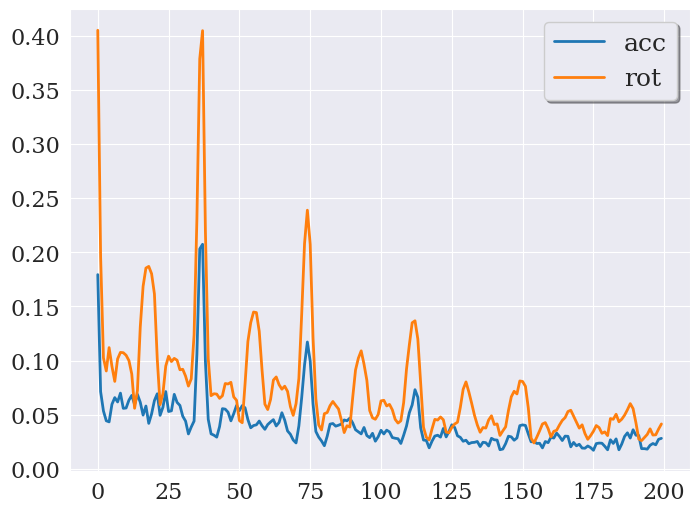

In [179]:
from skccm import Embed, CCM
from skccm.utilities import train_test_split

plt.figure(figsize=(8,6))

acc_emb_mutual_inf = Embed(data['acc']).mutual_information(200)
rot_emb_mutual_inf = Embed(data['rot']).mutual_information(200)

plt.plot(acc_emb_mutual_inf, label="acc")
plt.plot(rot_emb_mutual_inf, label="rot")

plt.legend(shadow=True, fontsize=18)
plt.show()

In [203]:
np.argmin(acc_emb_mutual_inf[:30]), np.argmin(rot_emb_mutual_inf[:30])

(18, 13)

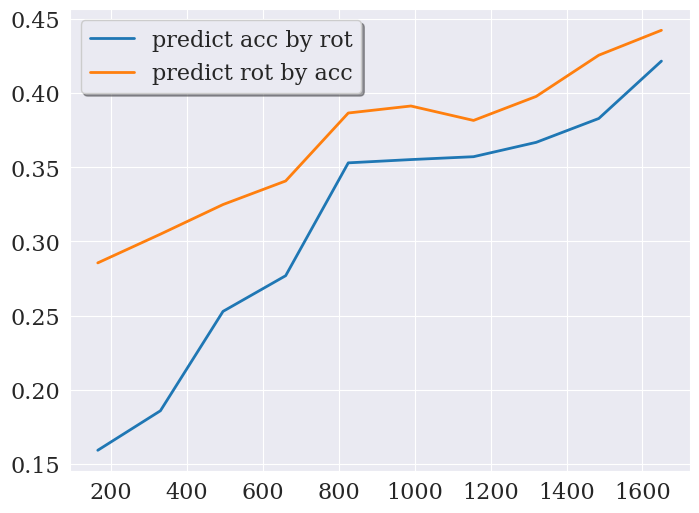

In [220]:
tau_acc = 18
tau_rot = 13

E = 8
L = 2200

ccm = CCM()
# X=data['acc'], Y=data['rot'], tau=tau_acc, E=E, L=L
acc_emb = Embed(data["acc"])
rot_emb = Embed(data["rot"])

X1 = acc_emb.embed_vectors_1d(tau_acc, E)[:L]
X2 = rot_emb.embed_vectors_1d(tau_rot, E)[:L]

x1_train, x1_test, x2_train, x2_test = train_test_split(X1,X2, percent=.75)

lib_lengths = np.linspace(len(x1_train)//10, len(x1_train), 10).astype(int)

ccm.fit(x1_train,x2_train)
x1_pred, x2_pred = ccm.predict(x1_test, x2_test,lib_lengths=lib_lengths)
score1, score2 = ccm.score()

plt.figure(figsize=(8,6))

plt.plot(lib_lengths, score1, label="predict acc by rot")
plt.plot(lib_lengths, score2, label="predict rot by acc")
plt.legend(shadow=True, fontsize=16)
plt.show()

Наилучший E получен перебором. Судя по скору, наблюдается довольно сильная зависимость между показателями гироскопа и акселерометра причем показатели второго предсказываются по первому лучше чем наоборот.

### Trajectories

In [221]:
import random
def plot_3d_trajectory(X, Y):
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1,2,1, projection='3d')

    if X.shape[-1] == 3:
        ind = [0,1,2]
    else:
        ind = random.sample(list(range(X.shape[-1])), 3)
    
    ax.plot(
        X[:2000,ind[0]],
        X[:2000,ind[1]],
        X[:2000,ind[2]],
        alpha=0.7,
        color=sns.color_palette()[2],
        marker=".",
        lw=1
    )

    ax.set_title("Acc")
    
    ax2 = fig.add_subplot(1,2,2, projection='3d')
    ax2.plot(
        Y[:2000,ind[0]],
        Y[:2000,ind[1]],
        Y[:2000,ind[2]],
        alpha=0.7,
        color=sns.color_palette()[3],
        marker=".",
        lw=1
    )
    

    ax2.set_title("Rot")
    
    plt.show()

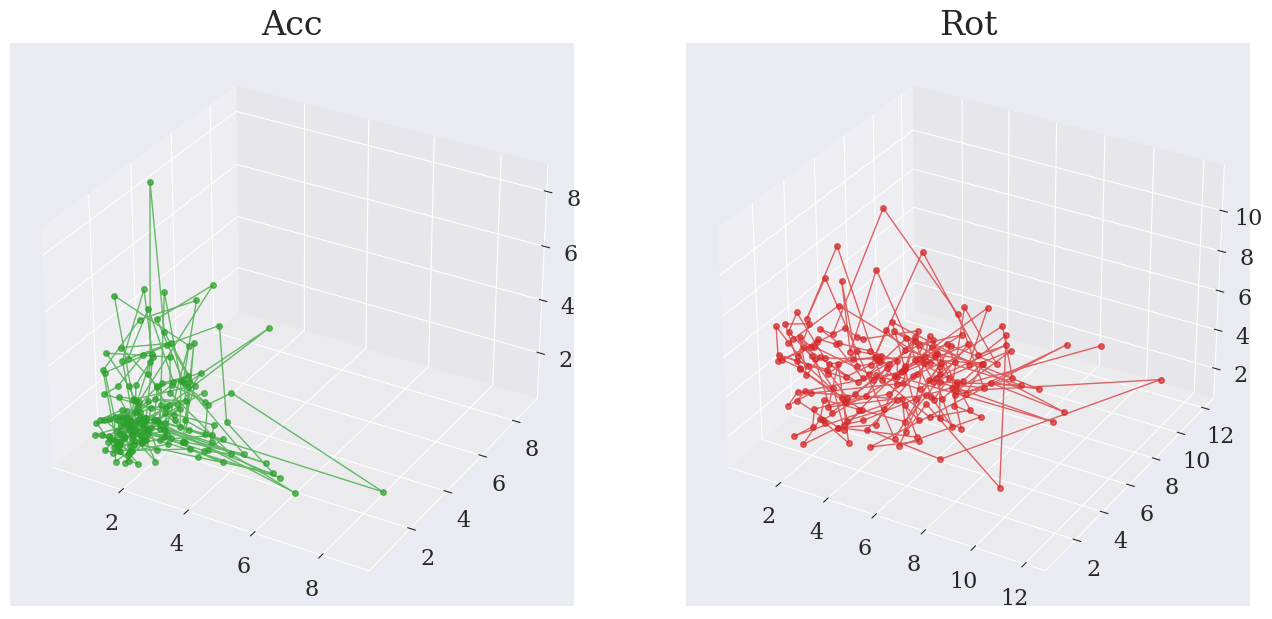

In [222]:
plot_3d_trajectory(X1[:200,:], X2[:200,:])

Без понижения размерности что-то не очень похоже

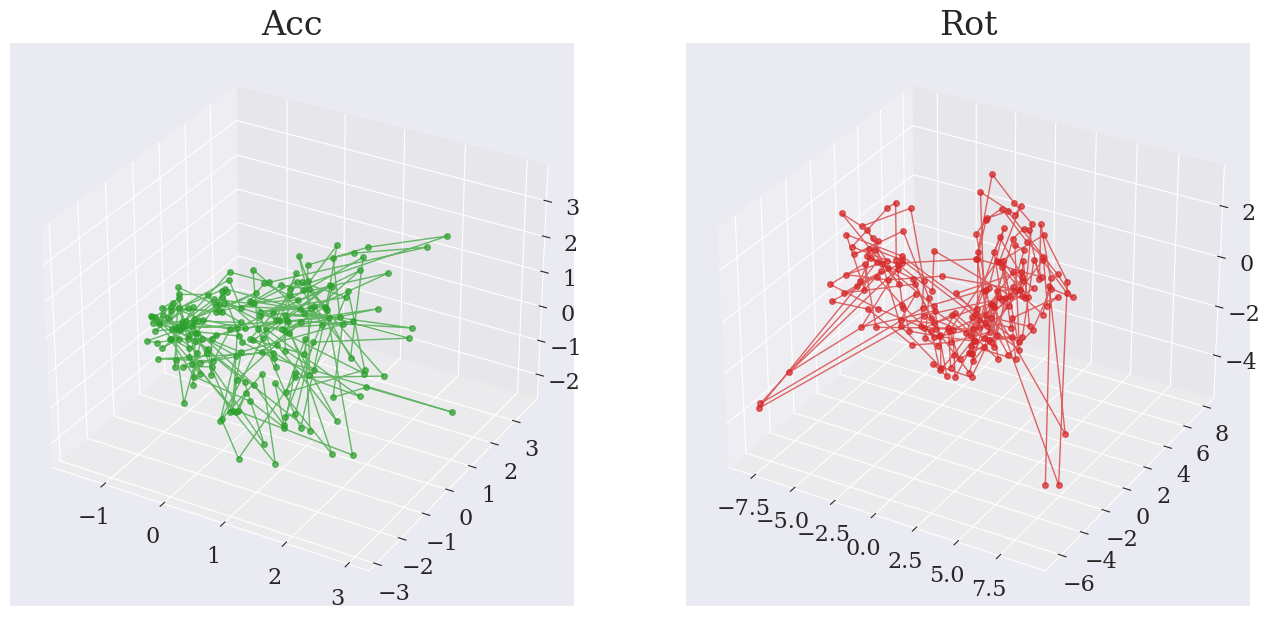

In [223]:
X1_pca = PCA(3).fit_transform(X1)
X2_pca = PCA(3).fit_transform(X2)

plot_3d_trajectory(X1_pca[:200,:], X2_pca[:200,:])

Все еще так себе

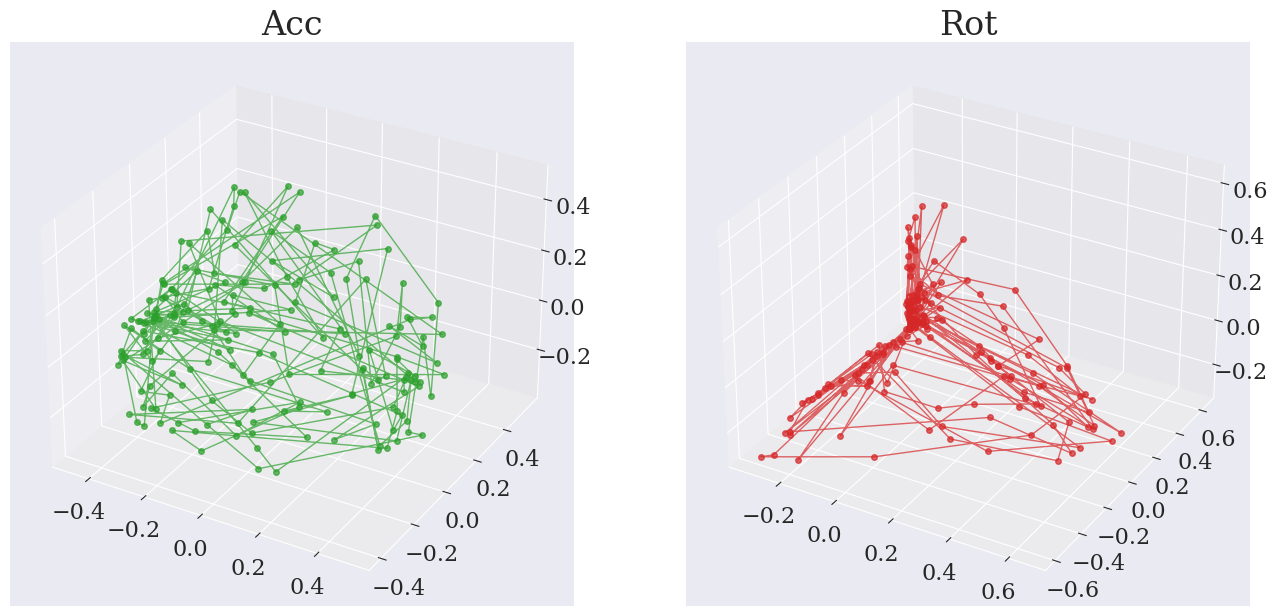

In [224]:
X1_kernel_pca = KernelPCA(3, kernel="rbf").fit_transform(X1)
X2_kernel_pca = KernelPCA(3, kernel="rbf").fit_transform(X2)

plot_3d_trajectory(X1_kernel_pca[:200,:], X2_kernel_pca[:200,:])

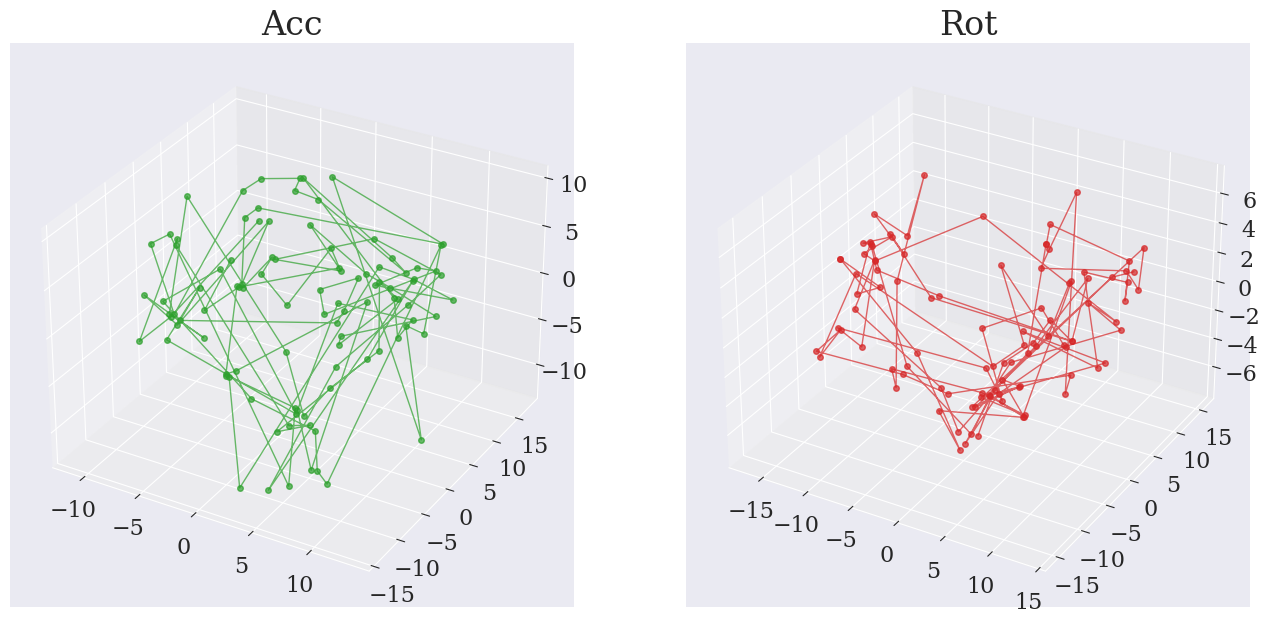

In [225]:
from sklearn.manifold import TSNE

X1_TSNE = TSNE(3).fit_transform(X1)
X2_TSNE = TSNE(3).fit_transform(X2)

plot_3d_trajectory(X1_TSNE[:100,:], X2_TSNE[:100,:])

Стало как будто ближе, но пока все еще ничего не очень

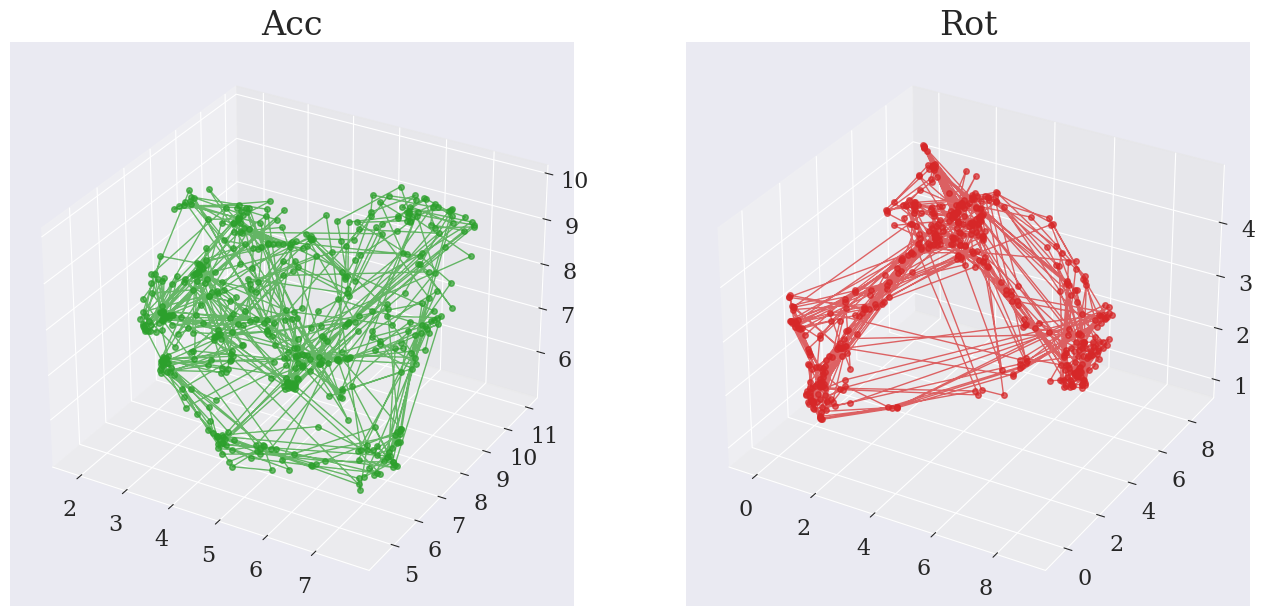

In [226]:
import umap

X1_umap = umap.UMAP(n_components=3).fit_transform(X1)
X2_umap = umap.UMAP(n_components=3).fit_transform(X2)

plot_3d_trajectory(X1_umap[:500,:], X2_umap[:500,:])

### Decomposition

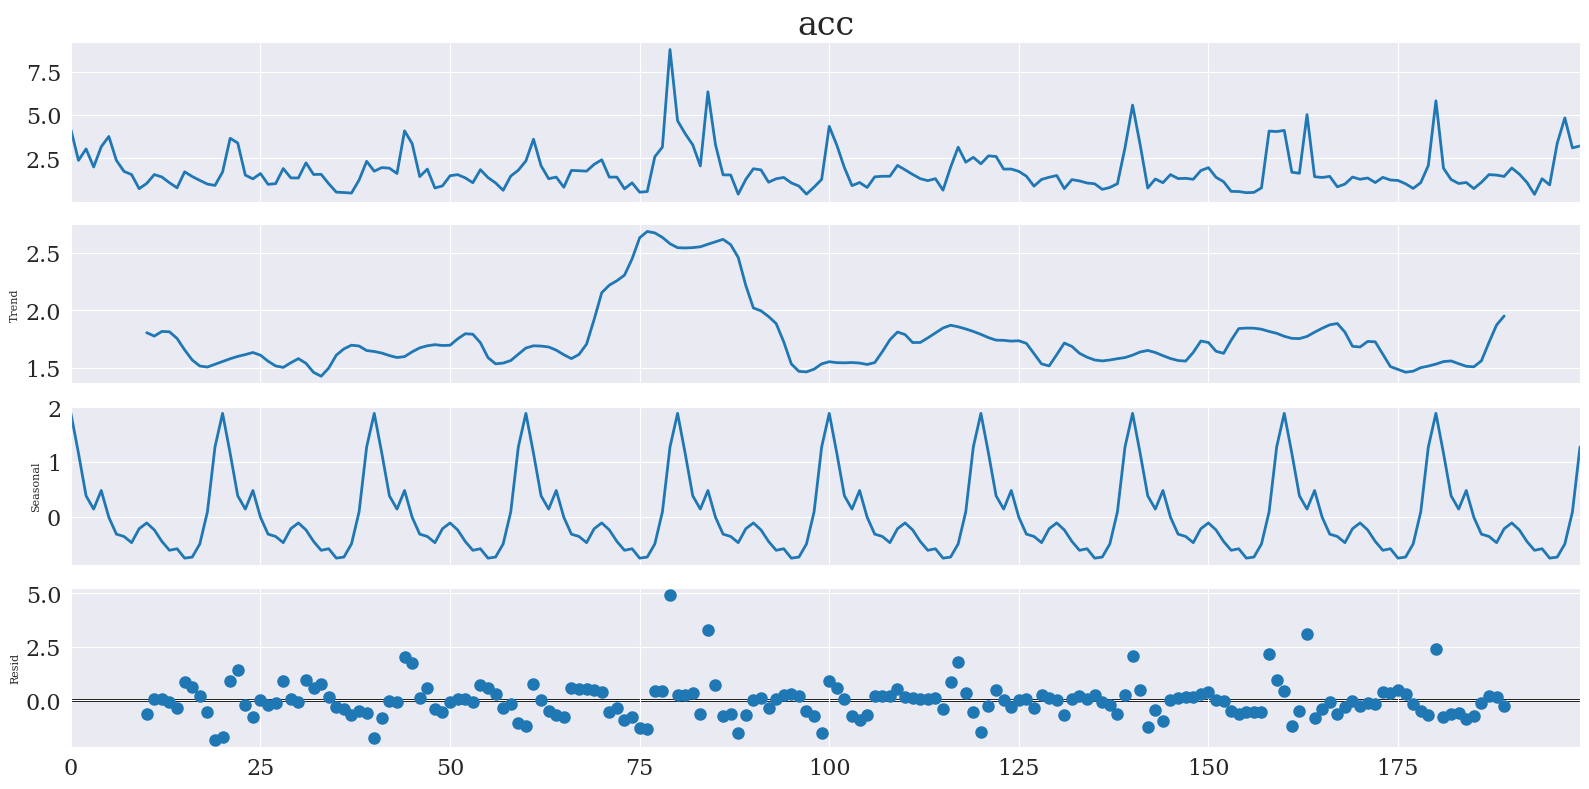

In [232]:
from statsmodels.tsa.seasonal import seasonal_decompose

acc_decomposed = seasonal_decompose(data["acc"][:200], period=20)
acc_decomposed.plot()
plt.show()

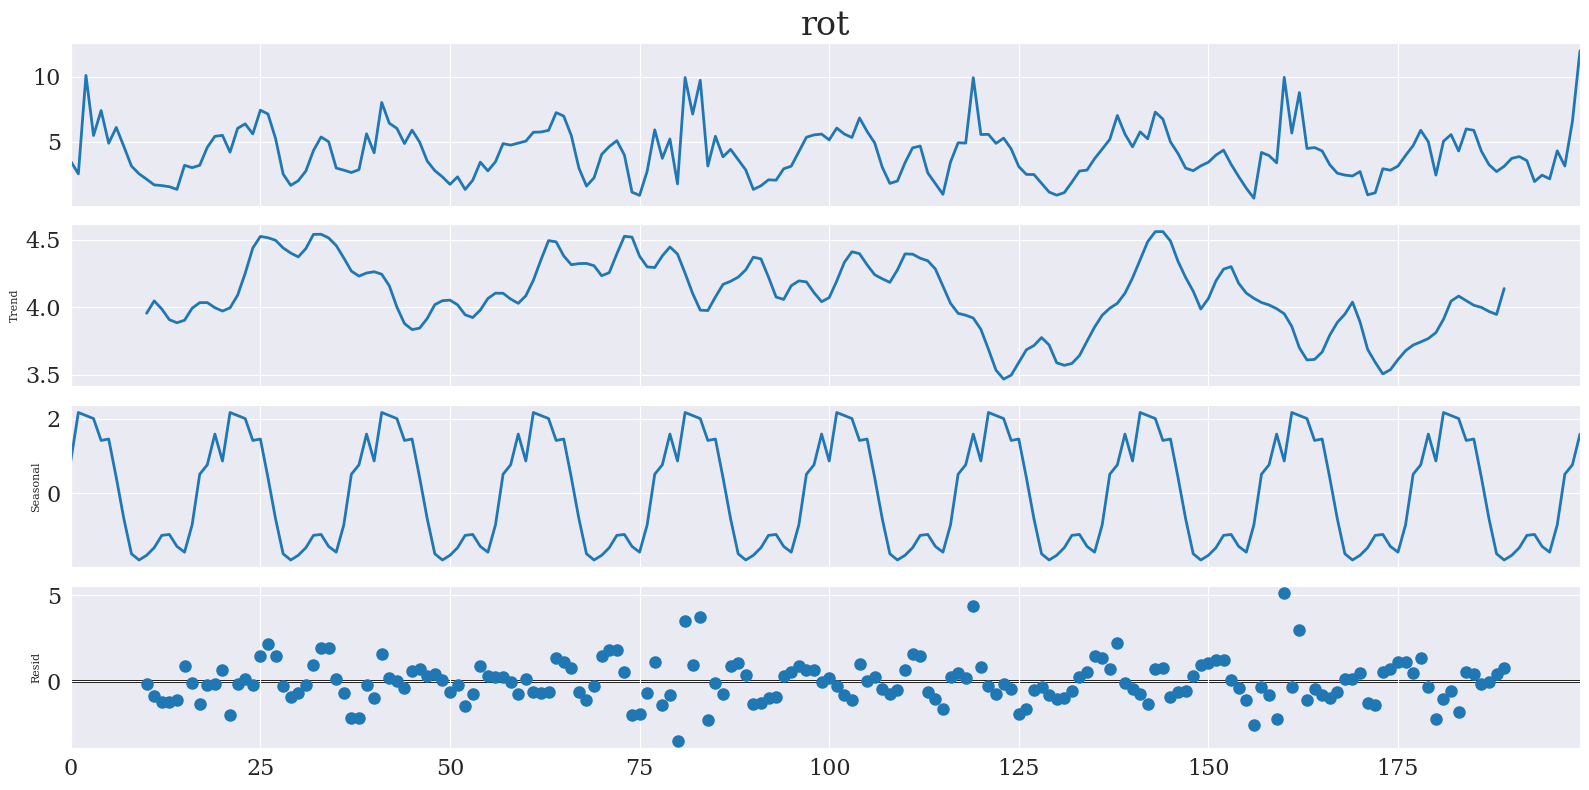

In [231]:
rot_decomposed = seasonal_decompose(data["rot"][:200], period=20)
rot_decomposed.plot()
plt.show()

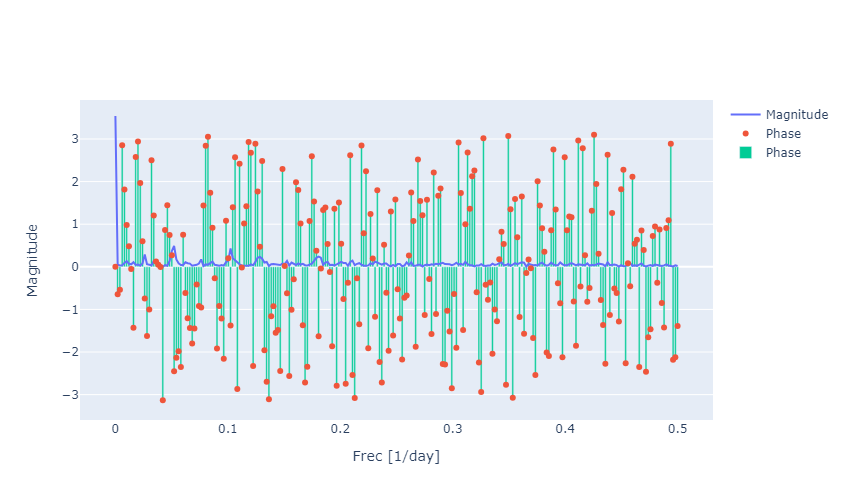

In [64]:
num_to_print = 500
ts = data["acc"][:500].to_numpy()
Fs = 1
N = len(ts)

temp_fft = fft(ts)[0:N//2]
__FS = np.linspace(0.0, 1.0/2.0 * Fs, N//2)
__Abs = 2.0/N * np.abs(temp_fft) #нормирование

# plotting the spectrum
layout = go.Layout(
    autosize=False,
    width=800,
    height=500,
)

fig = go.Figure(layout=layout)
fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Abs[0:num_to_print],
    mode='lines',
    name='Magnitude'
)

__Ph = np.arctan2(np.imag(temp_fft),np.real(temp_fft))

fig.add_scatter(
    x = __FS[0:num_to_print],
    y = __Ph[0:num_to_print],
    mode='markers',
    name='Phase'
)

fig.add_trace(
    go.Bar(
        x = __FS[0:num_to_print],
        y = __Ph[0:num_to_print],
        name='Phase'
    )
)

fig['layout']['yaxis1'].update(title='Magnitude')
fig['layout']['xaxis1'].update(title='Frec [1/day]')
fig.show()

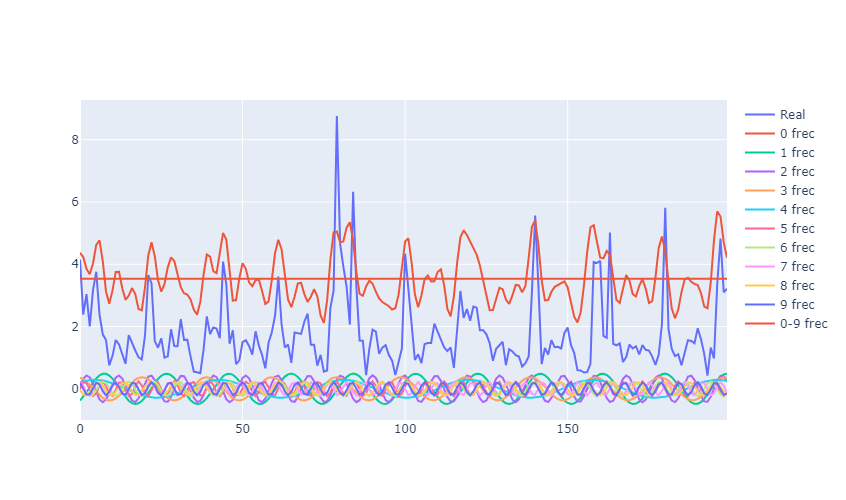

In [65]:
pd_Abs = pd.DataFrame(__Abs).sort_values(0, ascending=False)

n_fig = 200
fig = go.Figure(layout=layout)

fig.add_scatter(
    x = np.arange(n_fig),
    y = ts[:n_fig],
    mode = 'lines',
    name = 'Real')

t = np.arange(n_fig)

for i, ind in enumerate(pd_Abs.index.values[:10]):
  x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

  fig.add_scatter(
      x = t[:n_fig],
      y = x,
      mode='lines',
      name=f'{i} frec'
  )

for i, ind in enumerate(pd_Abs.index.values[:20]):
  if i == 0:
    x = __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])
  else:
    x+= __Abs[ind]*np.cos(2*np.pi*__FS[ind]*t + __Ph[ind])

fig.add_scatter(
    x = t[:n_fig],
    y = x,
    mode='lines',
    name='0-9 frec'
)

fig.show()

In [67]:
class SSA(object):
    
    __supported_types = (pd.Series, np.ndarray, list)
    
    def __init__(self, tseries, L, save_mem=True):
        """
        Decomposes the given time series with a singular-spectrum analysis. Assumes the values of the time series are
        recorded at equal intervals.
        
        Parameters
        ----------
        tseries : The original time series, in the form of a Pandas Series, NumPy array or list. 
        L : The window length. Must be an integer 2 <= L <= N/2, where N is the length of the time series.
        save_mem : Conserve memory by not retaining the elementary matrices. Recommended for long time series with
            thousands of values. Defaults to True.
        
        Note: Even if an NumPy array or list is used for the initial time series, all time series returned will be
        in the form of a Pandas Series or DataFrame object.
        """
        
        # Tedious type-checking for the initial time series
        if not isinstance(tseries, self.__supported_types):
            raise TypeError("Unsupported time series object. Try Pandas Series, NumPy array or list.")
        
        # Checks to save us from ourselves
        self.N = len(tseries)
        if not 2 <= L <= self.N/2:
            raise ValueError("The window length must be in the interval [2, N/2].")
        
        self.L = L
        self.orig_TS = pd.Series(tseries)
        self.K = self.N - self.L + 1
        
        # Embed the time series in a trajectory matrix
        self.X = np.array([self.orig_TS.values[i:L+i] for i in range(0, self.K)]).T
        
        # Decompose the trajectory matrix
        self.U, self.Sigma, VT = np.linalg.svd(self.X)
        self.d = np.linalg.matrix_rank(self.X)
        
        self.TS_comps = np.zeros((self.N, self.d))
        
        if not save_mem:
            # Construct and save all the elementary matrices
            self.X_elem = np.array([ self.Sigma[i]*np.outer(self.U[:,i], VT[i,:]) for i in range(self.d) ])

            # Diagonally average the elementary matrices, store them as columns in array.           
            for i in range(self.d):
                X_rev = self.X_elem[i, ::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.V = VT.T
        else:
            # Reconstruct the elementary matrices without storing them
            for i in range(self.d):
                X_elem = self.Sigma[i]*np.outer(self.U[:,i], VT[i,:])
                X_rev = X_elem[::-1]
                self.TS_comps[:,i] = [X_rev.diagonal(j).mean() for j in range(-X_rev.shape[0]+1, X_rev.shape[1])]
            
            self.X_elem = "Re-run with save_mem=False to retain the elementary matrices."
            
            # The V array may also be very large under these circumstances, so we won't keep it.
            self.V = "Re-run with save_mem=False to retain the V matrix."
        
        # Calculate the w-correlation matrix.
        self.calc_wcorr()
            
    def components_to_df(self, n=0):
        """
        Returns all the time series components in a single Pandas DataFrame object.
        """
        if n > 0:
            n = min(n, self.d)
        else:
            n = self.d
        
        # Create list of columns - call them F0, F1, F2, ...
        cols = ["F{}".format(i) for i in range(n)]
        return pd.DataFrame(self.TS_comps[:, :n], columns=cols, index=self.orig_TS.index)
            
    
    def reconstruct(self, indices):
        """
        Reconstructs the time series from its elementary components, using the given indices. Returns a Pandas Series
        object with the reconstructed time series.
        
        Parameters
        ----------
        indices: An integer, list of integers or slice(n,m) object, representing the elementary components to sum.
        """
        if isinstance(indices, int): indices = [indices]
        
        ts_vals = self.TS_comps[:,indices].sum(axis=1)
        return pd.Series(ts_vals, index=self.orig_TS.index)
    
    def calc_wcorr(self):
        """
        Calculates the w-correlation matrix for the time series.
        """
             
        # Calculate the weights
        w = np.array(list(np.arange(self.L)+1) + [self.L]*(self.K-self.L-1) + list(np.arange(self.L)+1)[::-1])
        
        def w_inner(F_i, F_j):
            return w.dot(F_i*F_j)
        
        # Calculated weighted norms, ||F_i||_w, then invert.
        F_wnorms = np.array([w_inner(self.TS_comps[:,i], self.TS_comps[:,i]) for i in range(self.d)])
        F_wnorms = F_wnorms**-0.5
        
        # Calculate Wcorr.
        self.Wcorr = np.identity(self.d)
        for i in range(self.d):
            for j in range(i+1,self.d):
                self.Wcorr[i,j] = abs(w_inner(self.TS_comps[:,i], self.TS_comps[:,j]) * F_wnorms[i] * F_wnorms[j])
                self.Wcorr[j,i] = self.Wcorr[i,j]
    
    def plot_wcorr(self, min=None, max=None):
        """
        Plots the w-correlation matrix for the decomposed time series.
        """
        if min is None:
            min = 0
        if max is None:
            max = self.d
        
        if self.Wcorr is None:
            self.calc_wcorr()
        
        ax = plt.imshow(self.Wcorr)
        plt.xlabel(r"$\tilde{F}_i$")
        plt.ylabel(r"$\tilde{F}_j$")
        plt.colorbar(ax.colorbar, fraction=0.045)
        ax.colorbar.set_label("$W_{i,j}$")
        plt.clim(0,1)
        
        # For plotting purposes:
        if max == self.d:
            max_rnge = self.d-1
        else:
            max_rnge = max
        
        plt.xlim(min-0.5, max_rnge+0.5)
        plt.ylim(max_rnge+0.5, min-0.5)

In [239]:
ssa = SSA(data["acc"][:500], L=20)

Text(0, 0.5, '$\\tilde{F}_i(t)$')

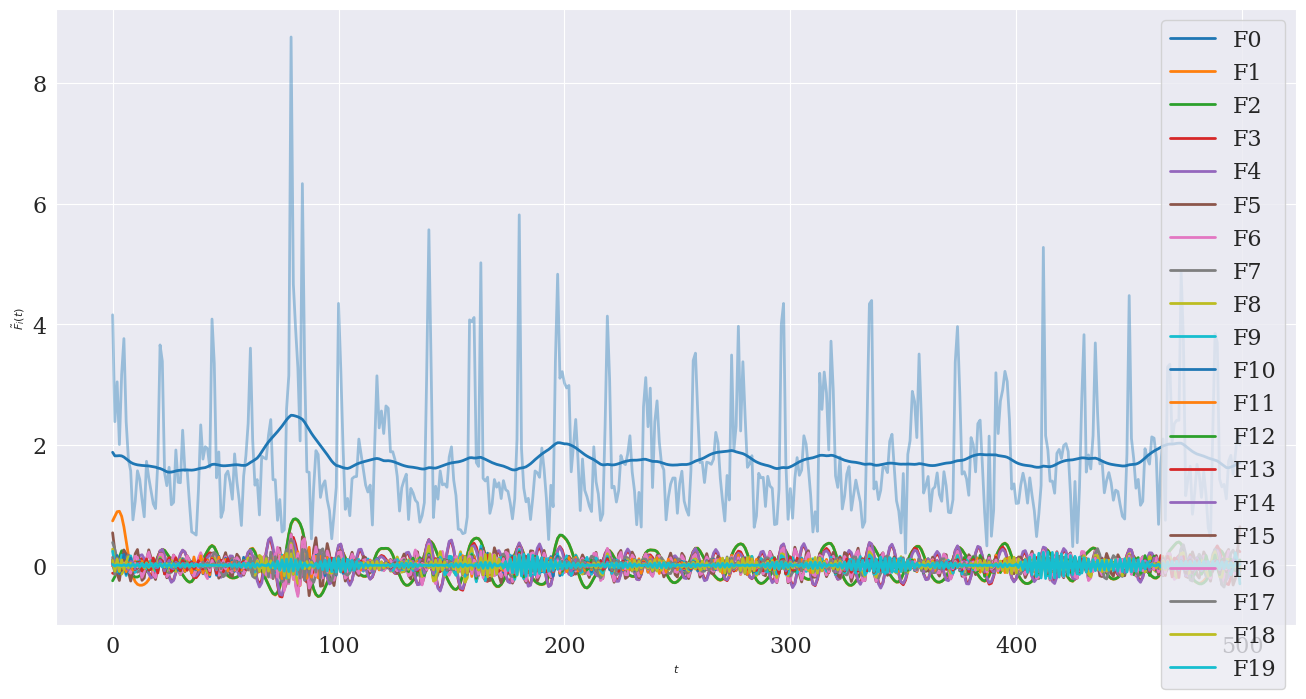

In [240]:
ssa.components_to_df().plot()
ssa.orig_TS.plot(alpha=0.4)
plt.xlabel("$t$")
plt.ylabel(r"$\tilde{F}_i(t)$")

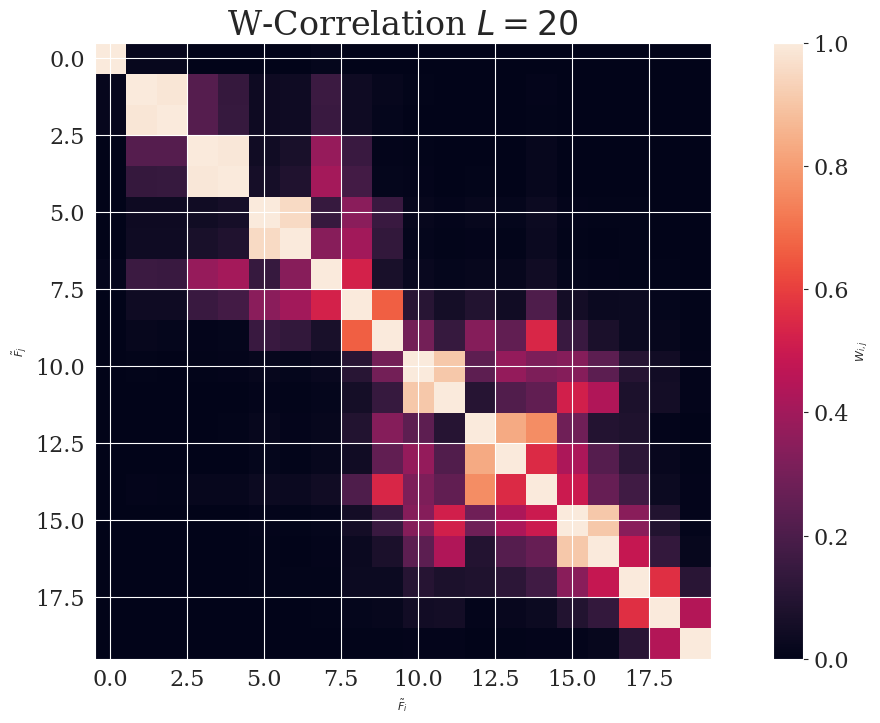

In [241]:
ssa.plot_wcorr()
plt.title("W-Correlation $L=20$");

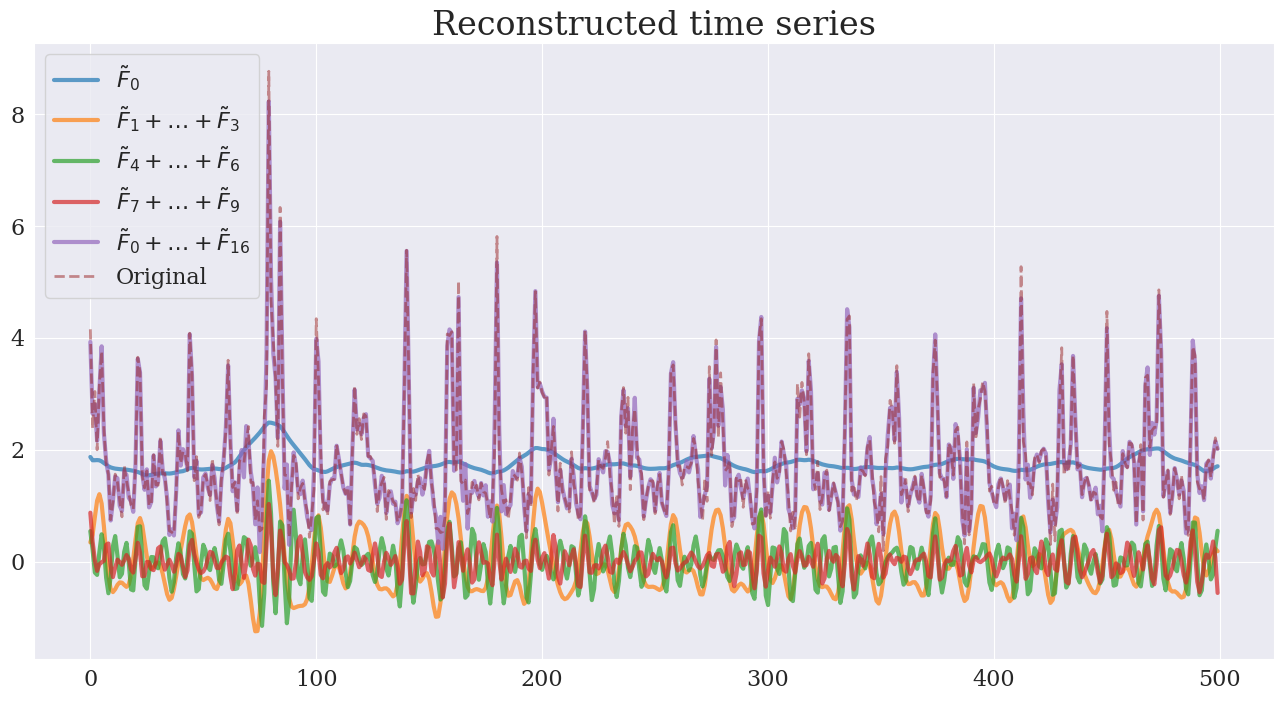

In [290]:
ssa.reconstruct(list(range(1))).plot(lw=3,alpha=0.7)
ssa.reconstruct(list(range(1,4))).plot(lw=3,alpha=0.7)
ssa.reconstruct(list(range(4,7))).plot(lw=3,alpha=0.7)
ssa.reconstruct(list(range(7,10))).plot(lw=3,alpha=0.7)
ssa.reconstruct(list(range(17))).plot(lw=3,alpha=0.7)

ssa.orig_TS.plot(color="#992222", ls="--", alpha=0.5)


plt.legend([r"$\tilde{F}_0$", 
            r"$\tilde{F}_1+ \ldots +\tilde{F}_3$", 
            r"$\tilde{F}_4+ \ldots + \tilde{F}_{6}$",
            r"$\tilde{F}_7+ \ldots + \tilde{F}_{9}$",
            r"$\tilde{F}_0+ \ldots + \tilde{F}_{16}$",
            r"Original"])
plt.title("Reconstructed time series")
plt.show()

### ARIMA

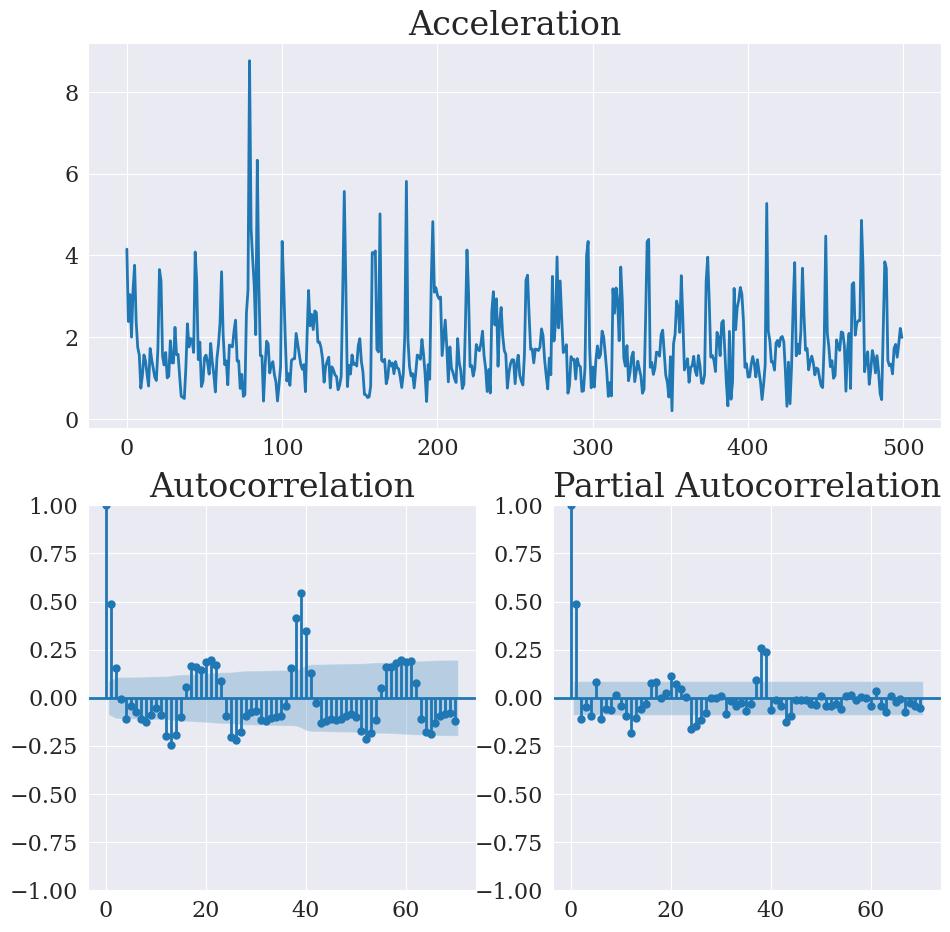

In [235]:
import statsmodels.tsa.api as smt
acc_data = data["acc"][:500].to_numpy()


fig, axs = plt.subplots(2, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(acc_data)
axbig.set_title('Acceleration')

smt.graphics.plot_acf(acc_data, lags=70, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(acc_data, lags=70, ax=axs[1,1], alpha=0.05)

plt.show()

Из графиков параметры для ARIMA: $S=40, P = 1, Q = 1$

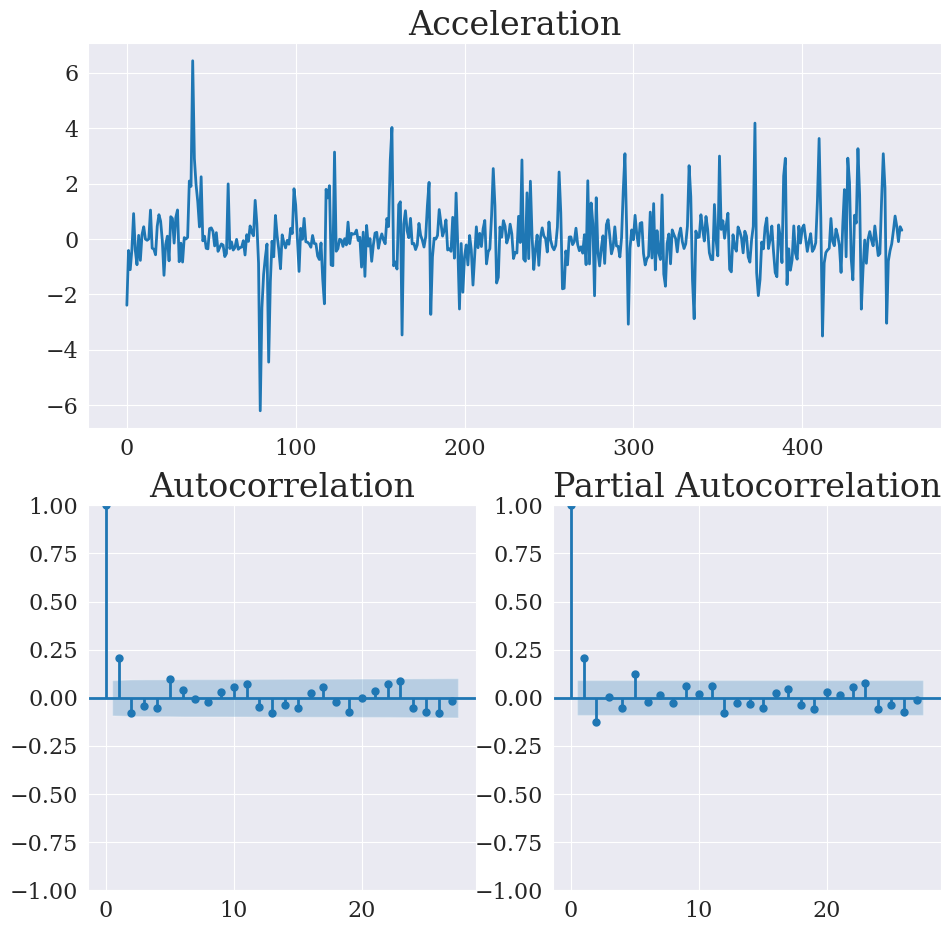

In [236]:
acc_data_diff = acc_data[40:] - acc_data[:-40]

fig, axs = plt.subplots(2, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(acc_data_diff)
axbig.set_title('Acceleration')

smt.graphics.plot_acf(acc_data_diff, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(acc_data_diff, ax=axs[1,1], alpha=0.05)

plt.show()

Отсюда $q=5, p=5, D=1$

In [262]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model_original_data = SARIMAX(acc_data, order=(5, 0, 2), seasonal_order=(1, 1, 1, 40)).fit()

preds_original_data = model_original_data.predict()
residuals_original_data = acc_data - preds_original_data

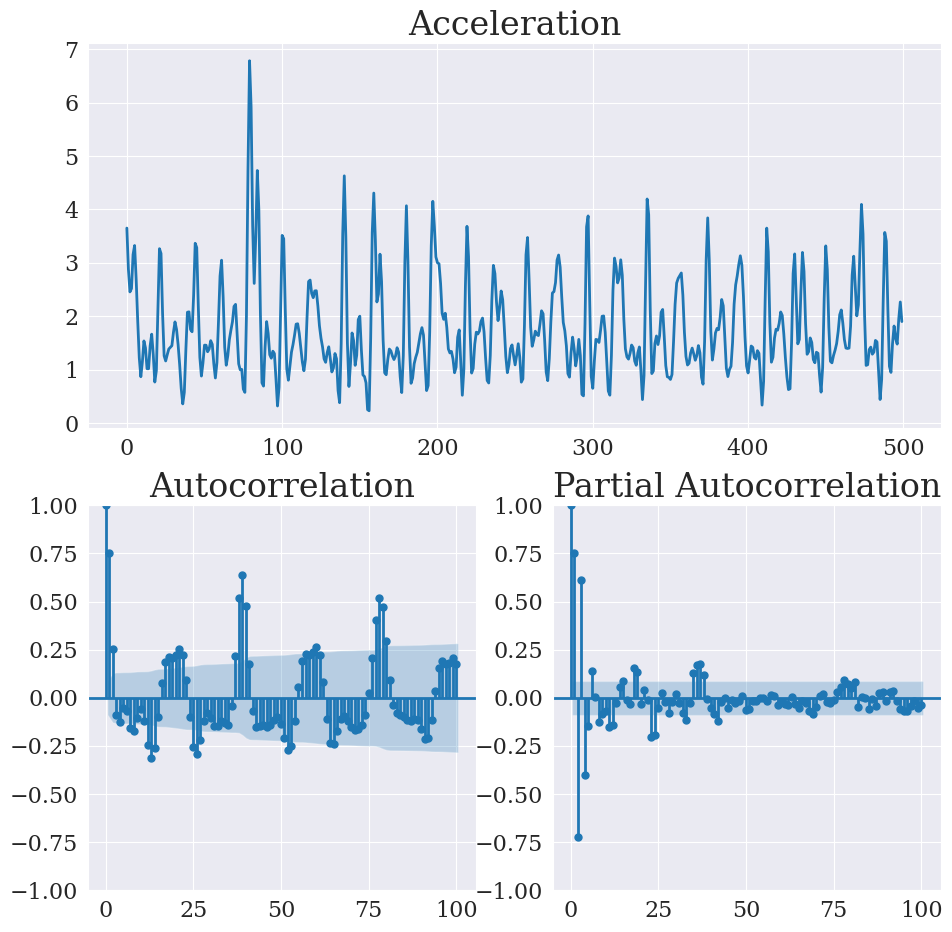

In [322]:
acc_data_ssa = ssa.reconstruct(list(range(10))).to_numpy()

fig, axs = plt.subplots(2, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(acc_data_ssa)
axbig.set_title('Acceleration')

smt.graphics.plot_acf(acc_data_ssa, lags=100, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(acc_data_ssa, lags=100, ax=axs[1,1], alpha=0.05)

plt.show()

In [323]:
acc_data_ssa_diff = acc_data_ssa[40:] - acc_data_ssa[:-40]

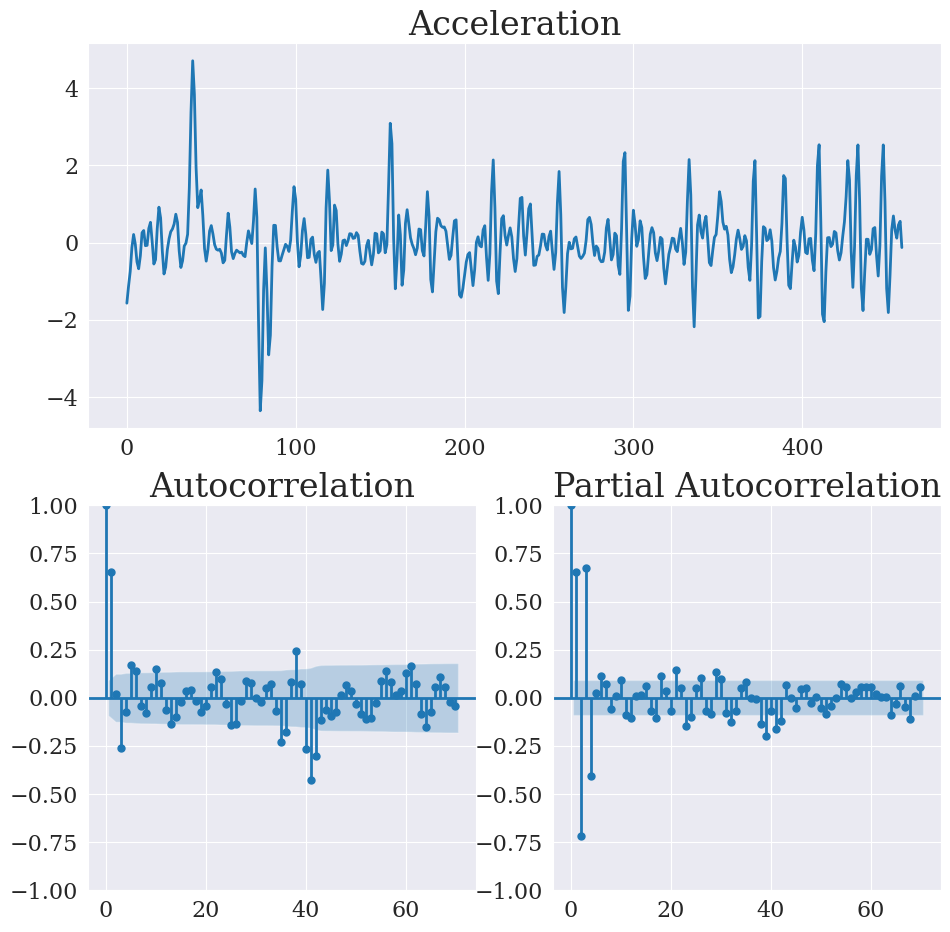

In [324]:
fig, axs = plt.subplots(2, 2, figsize = (11,11))
axs[0, 0].remove()
axs[0, 1].remove()

gs = axs[0, 0].get_gridspec()
axbig = fig.add_subplot(gs[0, :2])
axbig.plot(acc_data_ssa_diff)
axbig.set_title('Acceleration')

smt.graphics.plot_acf(acc_data_ssa_diff, lags=70, ax=axs[1,0], alpha=0.05)
smt.graphics.plot_pacf(acc_data_ssa_diff, lags=70, ax=axs[1,1], alpha=0.05)

plt.show()

Возьмем $S=40, P=1, Q=2, p=5, q=3, D=1, d=0$

In [325]:
model_ssa_data = SARIMAX(acc_data_ssa, order=(3, 0, 5), seasonal_order=(1, 1, 2, 40)).fit()

preds_ssa_data = model_ssa_data.predict()
residuals_ssa_data = acc_data - preds_ssa_data

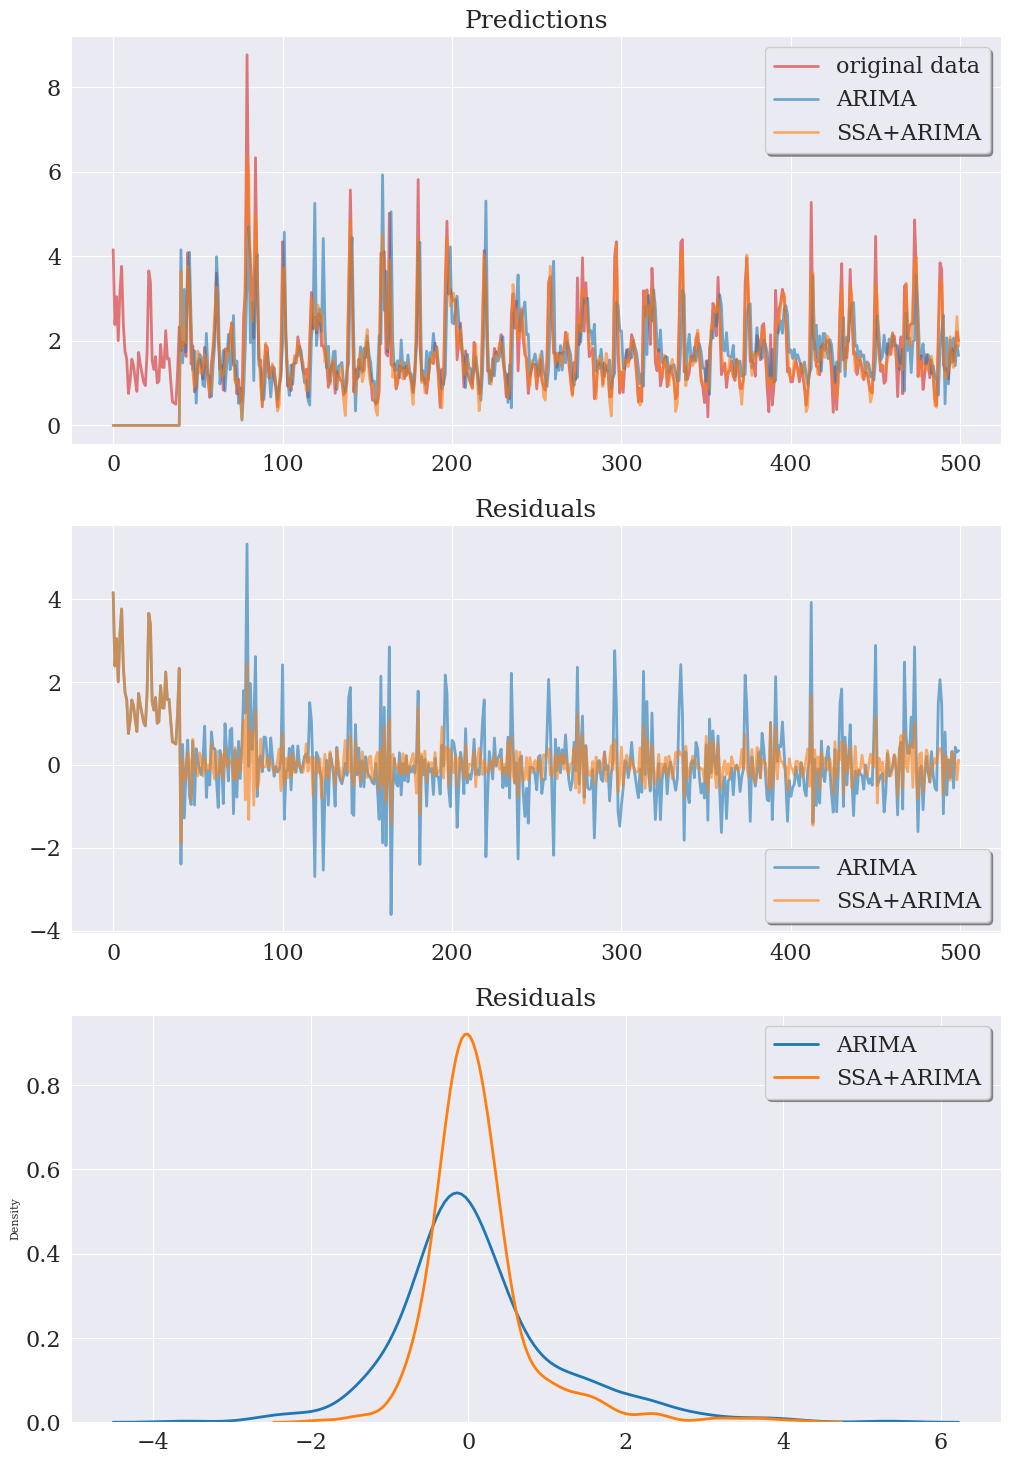

In [337]:
fig, axs = plt.subplots(3, 1, figsize = (12,18))

axs[0].plot(acc_data, label="original data", alpha=0.6, lw=2, color=sns.color_palette()[3])
axs[0].plot(preds_original_data, label="ARIMA", alpha=0.6, lw=2)
axs[0].plot(preds_ssa_data, label="SSA+ARIMA", alpha=0.6, lw=2)

axs[0].legend(shadow=True, fontsize=16)
axs[0].set_title('Predictions', fontsize=18)


axs[1].plot(residuals_original_data, label="ARIMA", alpha=0.6, lw=2)
axs[1].plot(residuals_ssa_data, label="SSA+ARIMA", alpha=0.6, lw=2)

axs[1].set_title('Residuals', fontsize=18)
axs[1].legend(shadow=True, fontsize=16)

sns.kdeplot(residuals_original_data, ax=axs[2], legend=False)
sns.kdeplot(residuals_ssa_data, ax=axs[2], legend=False)

axs[2].set_title('Residuals', fontsize=18)
axs[2].legend(labels=["ARIMA", "SSA+ARIMA"], shadow=True, fontsize=16)

plt.show()

In [328]:
model_original_data.aic, model_ssa_data.aic

(1248.1740981892203, -130.68383937081273)

Получается, что по AIC SSA+ARIMA гораздо лучше, о чем также говорят и графики остатков. Видимо это связано с отсевом шумовых компонент (строили модель на первых 17-ти из 20).